# Classifying cell types with neural networks

In this notebook, we will build a neural network that classifies cell types in the retinal bipolar dataset for Shekhar et al., 2016. These cells have been manually annotated, and here we will show that a neural network can recapitulate these cell type labels.

## 1. Imports

In [3]:
!pip install scprep

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim

import scprep

## 2. Loading the retinal bipolar data

We'll use the same retinal bipolar data you saw in preprocessing and visualization.

Alternatively, you may load your own data by replacing the Google Drive file ids with your own file ids.

Note that if you do, you will likely not have annotated celltype labels yet. Replace all references to `metadata['CELLTYPE']` with an entry from `metadata`, or your favorite gene.

In [5]:
scprep.io.download.download_google_drive("1GYqmGgv-QY6mRTJhOCE1sHWszRGMFpnf", "data.pickle.gz")
scprep.io.download.download_google_drive("1q1N1s044FGWzYnQEoYMDJOjdWPm_Uone", "metadata.pickle.gz")

In [6]:
data_raw = pd.read_pickle("data.pickle.gz")
metadata = pd.read_pickle("metadata.pickle.gz")

#### Converting data to `numpy` format

PyTorch expects data to be stored as a NumPy array.

In [7]:
data = scprep.reduce.pca(data_raw, n_components=50, method='dense').to_numpy()
data

array([[ -2.86639095,  16.11995588,   4.36943158, ...,  -1.56414345,
         -0.5269201 ,   3.09514901],
       [ -0.66863206,  13.21553129,  -4.8926386 , ...,  -0.23914979,
         -1.04694605,   1.14149672],
       [  0.29665496,   6.85551504,  18.19106786, ...,  -2.1821517 ,
          3.18519088,  -1.38017667],
       ...,
       [ 39.5113115 ,  -8.20886489, -10.16420662, ...,  -1.15785317,
          3.33891606,  -0.85663269],
       [  3.13934964,  15.10619606,   3.69472732, ...,  -1.15502515,
         -1.5222668 ,  -1.16064667],
       [ 42.90597659,  -9.79281524, -13.25215015, ...,   1.83467248,
          2.4724377 ,   1.60301547]])

For easier classification, we'll scale the data to have mean 0 and standard deviation 1 across all features.

In [8]:
data = data - data.mean(axis=0)
data = data / data.std(axis=0)
data

array([[-0.17060225,  1.43324626,  0.61033175, ..., -0.70251291,
        -0.2371874 ,  1.39822391],
       [-0.03979573,  1.17501009, -0.68341445, ..., -0.10741075,
        -0.47127146,  0.51566759],
       [ 0.01765635,  0.60953277,  2.54096809, ..., -0.98008257,
         1.43377929, -0.62349051],
       ...,
       [ 2.35163964, -0.72986086, -1.41975858, ..., -0.52003337,
         1.50297702, -0.38698115],
       [ 0.18684824,  1.34311156,  0.51608758, ..., -0.51876321,
        -0.68523197, -0.52431851],
       [ 2.55368378, -0.87069195, -1.85108928, ...,  0.8240172 ,
         1.11294114,  0.72415724]])

In [9]:
labels, cluster_names = pd.factorize(metadata['CELLTYPE'])
labels

array([ 0,  1,  2, ..., 20, 20, 20])

In [10]:
num_classes = len(np.unique(labels))
num_classes

29

#### Splitting the data into training and validation sets

We'll allocate 80\% of our data for training and 20\% for testing. You can also do this with scikit-learn:

```python
from sklearn.model_selection import train_test_split
data_training, data_validation, labels_training, labels_validation = train_test_split(
    data, labels, test_size=0.2)
```

In [11]:
# first let's split our data into training and validation sets
train_test_split = int(.8 * data.shape[0])

data_training = data[:train_test_split, :]
labels_training = labels[:train_test_split]
data_validation = data[train_test_split:, :]
labels_validation = labels[train_test_split:]
data_training.shape, data_validation.shape

((17241, 50), (4311, 50))

## 3. Moving Our Data to PyTorch Tensors 

By moving our data from numpy arrays to PyTorch Tensors, we can take advantage of the variety of tensor operations available. 

In [12]:
train_tensor = torch.from_numpy(data_training)
train_labels = torch.from_numpy(labels_training)

valid_tensor = torch.from_numpy(data_validation)
valid_labels = torch.from_numpy(labels_validation)
train_tensor

tensor([[-0.1706,  1.4332,  0.6103,  ..., -0.7025, -0.2372,  1.3982],
        [-0.0398,  1.1750, -0.6834,  ..., -0.1074, -0.4713,  0.5157],
        [ 0.0177,  0.6095,  2.5410,  ..., -0.9801,  1.4338, -0.6235],
        ...,
        [-0.8508, -0.5792, -0.2911,  ...,  0.4428,  0.7037, -0.7899],
        [-0.0301,  1.3992, -0.1076,  ...,  0.9551, -1.0958, -0.9961],
        [-0.8086, -0.8436,  0.2160,  ...,  0.7730, -1.1515,  1.3104]],
       dtype=torch.float64)

Let's go ahead and check that our tensors are the expected sizes. We can do this identically to how we've previously done it with numpy arrays

In [13]:
# check shapes
print("train tensor shape: {}".format(train_tensor.shape))
print("train labels shape: {}".format(train_labels.shape))

print("valid tensor shape: {}".format(valid_tensor.shape))
print("valid labels shape: {}".format(valid_labels.shape))

train tensor shape: torch.Size([17241, 50])
train labels shape: torch.Size([17241])
valid tensor shape: torch.Size([4311, 50])
valid labels shape: torch.Size([4311])


## Exercise 1 - Tensor Operations 1

1. Create a tensor called x of values (0, 1, ..., 18, 19) using torch.arange(). Check the PyTorch documentation for [help](https://pytorch.org/docs/master/generated/torch.arange.html)

2. Reshape this tensor to shape (4,5)

2. Add the constant 5 to x and save this tensor as y

3. Power the values of y to 3rd power and save this tensor as z

4. Print the first row of z



In [15]:
# create x using torch.arange()
x = torch.arange(20)

# reshape to (4,5)
x = x.reshape(4, 5)

# add 5
y = x + 5

# power y to the 3rd power
z = y ** 3

# print the first row of z
print(z[0])

tensor([125, 216, 343, 512, 729])


## Exercise 2 - Tensor Operations 2

1. Subset the training tensor by taking the last 5 rows

2. Double the values and print the result.


In [16]:
# Get the last five rows of `train_tensor`
data_last5 = train_tensor[-5:]

# Multiply by two
last5_double = data_last5 * 2

# Print the result
last5_double

tensor([[-4.2113e-01,  1.2117e+00,  2.1553e+00,  7.8266e-02,  3.1221e+00,
         -3.4544e+00,  2.6318e+00, -9.3453e-01,  1.4304e+00, -5.3967e+00,
          4.0116e+00, -1.2537e+00, -3.0380e-01, -1.2594e+00,  8.9436e-01,
          1.3341e+00,  1.4379e+00, -1.0144e+00, -1.0536e-01, -1.0252e+00,
          2.5382e+00, -4.3350e+00, -1.5343e+00, -2.6249e+00, -3.0695e+00,
          1.3132e+00,  2.0608e-01, -3.4533e+00, -1.3922e+00, -1.9192e+00,
          1.3869e+00, -3.6863e-01,  2.8523e+00,  1.0865e+00,  5.5272e-01,
         -2.3816e+00,  5.6908e-01, -1.0946e+00, -1.9942e+00,  3.0005e+00,
          7.3449e-01,  1.6254e+00, -1.1886e-03, -2.9385e+00,  3.4135e-01,
          1.8727e+00, -8.2173e-02, -9.2632e-01,  1.4066e+00, -1.4675e+00],
        [-5.7734e-01,  2.0474e+00,  7.9776e-01, -1.3401e+00,  5.4539e-01,
         -2.8550e+00,  2.3354e+00,  6.9714e+00, -2.1631e-02, -9.7053e-01,
          6.3472e-01, -3.3481e+00, -3.7750e-02,  2.7904e-01, -2.2654e+00,
          2.5538e+00, -1.8863e+00, -1

## 4. Building a one-layer neural network

Now we know how to write simple recipes in PyTorch, we can create a more complex instruction set defining a simple neural network with a single hidden layer.

In [20]:
class layer(nn.Module):
  def __init__(self, input_size, output_size, activation=None):
    super(layer, self).__init__()

    self.weight = nn.Parameter(torch.randn(input_size, output_size).double(), requires_grad=True)
    self.bias = nn.Parameter(torch.randn(output_size).double(), requires_grad=True)
    self.activation = activation
  
  def forward(self, x):
    output = torch.matmul(x, self.weight) + self.bias
    if self.activation is not None:
      output = self.activation(output)
    
    return output

Now, we can make two copies of this layer and stack them together to make a simple neural network.

In [24]:
input_size = data_training.shape[1]
num_hidden = 10

layer_1 = layer(input_size, num_hidden, activation=nn.ReLU())
layer_2 = layer(num_hidden, num_classes, activation=nn.Softmax(dim=-1))

# create a hidden (middle) layer
hidden_layer = layer_1(train_tensor)

# create the output layer used to classify
output = layer_2(hidden_layer)

output

tensor([[1.7824e-09, 1.8877e-13, 5.1655e-17,  ..., 9.7186e-01, 1.1456e-12,
         1.0818e-12],
        [3.7985e-08, 3.8823e-11, 7.5143e-20,  ..., 1.8815e-07, 3.6700e-16,
         2.2813e-20],
        [4.7946e-03, 5.9385e-04, 2.1726e-05,  ..., 7.4548e-01, 7.4626e-04,
         5.0330e-04],
        ...,
        [3.2324e-08, 9.2738e-06, 9.3613e-08,  ..., 9.9731e-01, 3.9593e-12,
         1.0557e-10],
        [6.2275e-06, 8.9331e-11, 6.1903e-16,  ..., 1.4423e-16, 1.8854e-16,
         7.3200e-33],
        [5.9793e-16, 3.6027e-14, 9.1556e-25,  ..., 1.0000e+00, 4.2570e-14,
         4.6630e-11]], dtype=torch.float64, grad_fn=<SoftmaxBackward>)

#### Build the loss function

In order to train our neural network, we need to define a loss function which tells us how well (or how poorly) our classifier performed.

Here, we'll use the cross-entropy loss which we discussed in lecture.

In [25]:
def to_one_hot(y_tensor, c_dims):
    """converts a N-dimensional input to a NxC dimnensional one-hot encoding
    """
    y_tensor = torch.LongTensor(y_tensor)
    y_tensor = y_tensor.type(torch.LongTensor).view(-1, 1)
    c_dims = c_dims if c_dims is not None else int(torch.max(y_tensor)) + 1
    y_one_hot = torch.zeros(y_tensor.size()[0], c_dims).scatter_(1, y_tensor, 1)
    y_one_hot = y_one_hot.view(*y_tensor.shape, -1)
    return y_one_hot.squeeze()

In [26]:
# convert our integer class labels to a binary "one-hot" matrix
labels_one_hot = to_one_hot(train_labels, num_classes)
labels_one_hot

tensor([[1., 0., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

In [27]:
# compute cross entropy
loss = labels_one_hot * torch.log(output+ 1e-6) + (1 - labels_one_hot) * torch.log(1 - output + 1e-6)
loss = -1 * loss.sum()
loss

tensor(263100.2586, dtype=torch.float64, grad_fn=<MulBackward0>)

#### Creating a model with PyTorch

Now let's use some PyTorch magic and create a model using `nn.Sequential`, which we can just treat as some fancy list for PyTorch layers. One of the benefits of this is that we can use `model.parameters()` to pull out the list of network parameters to be optimized.

In [28]:
model = nn.Sequential(layer_1, layer_2)
print(model)

Sequential(
  (0): layer(
    (activation): ReLU()
  )
  (1): layer(
    (activation): Softmax(dim=-1)
  )
)


We can now obtain the output of our model by simply calling `model(data)`.

In [29]:
model(train_tensor)

tensor([[1.7824e-09, 1.8877e-13, 5.1655e-17,  ..., 9.7186e-01, 1.1456e-12,
         1.0818e-12],
        [3.7985e-08, 3.8823e-11, 7.5143e-20,  ..., 1.8815e-07, 3.6700e-16,
         2.2813e-20],
        [4.7946e-03, 5.9385e-04, 2.1726e-05,  ..., 7.4548e-01, 7.4626e-04,
         5.0330e-04],
        ...,
        [3.2324e-08, 9.2738e-06, 9.3613e-08,  ..., 9.9731e-01, 3.9593e-12,
         1.0557e-10],
        [6.2275e-06, 8.9331e-11, 6.1903e-16,  ..., 1.4423e-16, 1.8854e-16,
         7.3200e-33],
        [5.9793e-16, 3.6027e-14, 9.1556e-25,  ..., 1.0000e+00, 4.2570e-14,
         4.6630e-11]], dtype=torch.float64, grad_fn=<SoftmaxBackward>)

#### Create the optimizer

To update the model parameters, PyTorch does all of the heavy lifting for us. The optimizer takes the loss value and calculates how we should change the network weights to improve our results.

In [30]:
# now we need an optimizer that we'll give this loss, and it'll take responsibility
# for updating the network to make this score go down
learning_rate = 0.001

optimizer = optim.SGD(model.parameters(),
                      lr=learning_rate)


# how many data points do we want to calculate at once?
batch_size = 128

#### Train the network

Let's train the network for 100 _epochs_. An epoch is defined as having optimized our weights over all of our data points exactly once.

In [33]:
# tain the network for 100 epochs
step = 0
print_every = 50
results = {
    'train_loss': [],
    'train_acc': [],
    'val_acc': [],
}

for epoch in range(100):
  # randomize the order in which we see the data in each epoch
  random_order_indices = np.random.choice(train_tensor.shape[0], train_tensor.shape[0], replace=False)

  # iterate through the data in batches of size `batch_size`
  for batch_indices in np.array_split(random_order_indices, random_order_indices.shape[0] // batch_size):
    train_data_batch = train_tensor[batch_indices]
    train_labels_batch = train_labels[batch_indices]
    train_onehot = to_one_hot(train_labels_batch, num_classes)

    step += 1

    # get pass through layers
    output = model(train_data_batch)

    # compute cross entropy
    loss = train_onehot * torch.log(output+ 1e-6) + (1-train_onehot)*torch.log(1 - output + 1e-6)
    loss = -1 * loss.sum()

    # backpropagate the loss
    loss.backward()

    # update parameters
    optimizer.step()

    # reset gradients
    optimizer.zero_grad()

    # evaluate accuracy on both the training and validation datasets
    if step % print_every == 0:
      # don't track gradients
      with torch.no_grad():
        # compute the predicted output
        train_prediction = output.argmax(1).numpy()
        # compute the accuracy over the batch
        acc_training = np.mean(train_prediction == train_labels_batch.numpy())

        # compute the loss on all the validation data
        loss_np = []
        output_np = []
        labels_np = []

        random_order_indices = np.random.choice(valid_tensor.shape[0], valid_tensor.shape[0], replace=False)

        for batch_indices in np.array_split(random_order_indices, random_order_indices.shape[0] // batch_size):
          valid_data_batch = valid_tensor[batch_indices]
          valid_labels_batch = valid_labels[batch_indices]

          # pass thru layers 
          valid_output = model(valid_data_batch)

          # compute the predicted outputs
          prediction_np = valid_output.argmax(1).numpy()
          output_np.append(prediction_np.reshape(-1))
          labels_np.append(valid_labels_batch.numpy().reshape(-1))
        
        # compute the accuracy over the whole dataset
        output_np = np.concatenate(output_np)
        labels_np = np.concatenate(labels_np)
        acc_validation = np.mean(output_np == labels_np)

        results['train_loss'].append(loss.item())
        results['train_acc'].append(acc_training)
        results['val_acc'].append(acc_validation)
        print('Step {} loss: {:.3f} training accuracy: {:.3f} validation accuracy: {:.3f} '.format(
                    step, loss.item(), acc_training, acc_validation))

Step 50 loss: 520.138 training accuracy: 0.496 validation accuracy: 0.427 
Step 100 loss: 355.524 training accuracy: 0.586 validation accuracy: 0.474 
Step 150 loss: 321.356 training accuracy: 0.612 validation accuracy: 0.527 
Step 200 loss: 330.308 training accuracy: 0.636 validation accuracy: 0.550 
Step 250 loss: 273.186 training accuracy: 0.680 validation accuracy: 0.592 
Step 300 loss: 214.459 training accuracy: 0.674 validation accuracy: 0.614 
Step 350 loss: 233.774 training accuracy: 0.682 validation accuracy: 0.637 
Step 400 loss: 166.817 training accuracy: 0.750 validation accuracy: 0.638 
Step 450 loss: 183.559 training accuracy: 0.783 validation accuracy: 0.667 
Step 500 loss: 194.308 training accuracy: 0.695 validation accuracy: 0.676 
Step 550 loss: 175.418 training accuracy: 0.752 validation accuracy: 0.682 
Step 600 loss: 173.469 training accuracy: 0.744 validation accuracy: 0.691 
Step 650 loss: 183.056 training accuracy: 0.766 validation accuracy: 0.698 
Step 700 loss

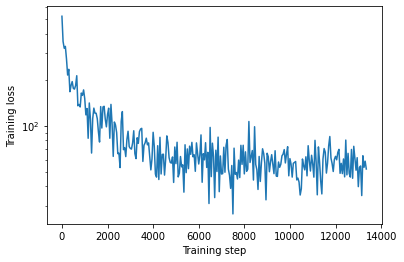

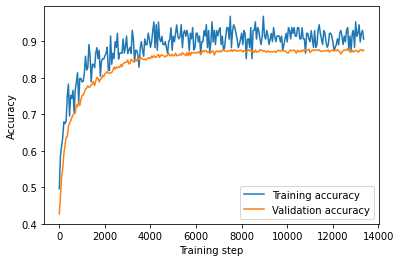

In [34]:
plt.figure()
plt.plot(np.arange(len(results['train_loss'])) * print_every, results['train_loss'])
plt.xlabel('Training step')
plt.ylabel('Training loss')
plt.yscale('log')

plt.figure()
plt.plot(np.arange(len(results['train_loss'])) * print_every, results['train_acc'], label='Training accuracy')
plt.plot(np.arange(len(results['train_loss'])) * print_every, results['val_acc'], label='Validation accuracy')
plt.xlabel('Training step')
plt.ylabel('Accuracy')
plt.legend()

### Discussion

1. How did our network do? Is the classification accuracy high?
  - classification accuracy is pretty high - 95% 
2. How many iterations did it take for the training accuracy to stop increasing?
  - converged around 6,000 steps
3. How many iterations did it take for the training loss to stop decreasing?
  - converged after around 10,000 steps
4. How many iterations did it take for the validation accuracy to stop increasing?
  - converged after around 4,000 steps

## Exercise 3 - network width

Create a network with a wider hidden layer and compare its performance to the network with 10 hidden neurons we just built.

In [35]:
# let's set some hyperparameters
batch_size = 128
learning_rate = 0.001
n_epochs = 100
print_every = 50
# ========
# Build the neural network with a wider hidden layer
num_hidden = 100
# ========

# build the neural network
layer_1 = layer(input_size, num_hidden, activation=nn.ReLU())
layer_2 = layer(num_hidden, num_classes, activation=nn.Softmax(dim=-1))

# create the model
model = nn.Sequential(layer_1, layer_2)

# create the optimizer
optimizer = optim.SGD(model.parameters(),
                      lr=learning_rate)

# train the network
step = 0
results = {
    'train_loss': [],
    'train_acc': [],
    'val_acc': [],
}
for epoch in range(n_epochs):
    # randomize the order in which we see the data in each epoch
    random_order_indices = np.random.choice(train_tensor.shape[0], train_tensor.shape[0], replace=False)
    
    # iterate through the data in batches of size `batch_size`
    for batch_indices in np.array_split(random_order_indices, random_order_indices.shape[0] // batch_size):
      
        train_data_batch = train_tensor[batch_indices]
        train_labels_batch = train_labels[batch_indices]
        train_onehot = to_one_hot(train_labels_batch, num_classes)

        step += 1

        # get pass batch through layers
        output = model(train_data_batch)

        # compute cross entropy
        loss = train_onehot * torch.log(output+ 1e-6) + (1 - train_onehot) * torch.log(1 - output + 1e-6)
        loss = -1 * loss.sum()

        # backpropagate the loss
        loss.backward()

        # update parameters
        optimizer.step()

        # reset gradients
        optimizer.zero_grad()

        # evaluate accuracy on both the training and validation datasets
        if step % print_every == 0:
            
            # don't track gradients
            with torch.no_grad():
                # compute the predicted outputs
                train_prediction = output.argmax(1).numpy()

                # compute the accuracy over the batch
                acc_training = np.mean(train_prediction == train_labels_batch.numpy())

                # compute the loss on all the validation data
                loss_np = []
                output_np = []
                labels_np = []

                random_order_indices = np.random.choice(valid_tensor.shape[0], valid_tensor.shape[0], replace=False)

                for batch_indices in np.array_split(random_order_indices, random_order_indices.shape[0] // batch_size):
                    valid_data_batch = valid_tensor[batch_indices]
                    valid_labels_batch = valid_labels[batch_indices]

                    # pass through layers
                    valid_output = model(valid_data_batch)

                    # compute the predicted outputs

                    prediction_np = valid_output.argmax(1).numpy()

                    output_np.append(prediction_np.reshape(-1))
                    labels_np.append(valid_labels_batch.numpy().reshape(-1))

                    
                # compute the accuracy over the whole dataset
                output_np = np.concatenate(output_np)
                labels_np = np.concatenate(labels_np)
                acc_validation = np.mean(output_np == labels_np)

                results['train_loss'].append(loss.item())
                results['train_acc'].append(acc_training)
                results['val_acc'].append(acc_validation)
                print('Step {} loss: {:.3f} training accuracy: {:.3f} validation accuracy: {:.3f} '.format(
                    step, loss.item(), acc_training, acc_validation))

Step 50 loss: 2790.705 training accuracy: 0.085 validation accuracy: 0.175 
Step 100 loss: 1335.559 training accuracy: 0.586 validation accuracy: 0.466 
Step 150 loss: 1342.005 training accuracy: 0.581 validation accuracy: 0.544 
Step 200 loss: 1198.721 training accuracy: 0.612 validation accuracy: 0.566 
Step 250 loss: 709.681 training accuracy: 0.766 validation accuracy: 0.595 
Step 300 loss: 806.054 training accuracy: 0.736 validation accuracy: 0.608 
Step 350 loss: 843.297 training accuracy: 0.690 validation accuracy: 0.618 
Step 400 loss: 1121.945 training accuracy: 0.633 validation accuracy: 0.633 
Step 450 loss: 840.436 training accuracy: 0.729 validation accuracy: 0.641 
Step 500 loss: 871.919 training accuracy: 0.727 validation accuracy: 0.643 
Step 550 loss: 774.193 training accuracy: 0.744 validation accuracy: 0.650 
Step 600 loss: 810.210 training accuracy: 0.736 validation accuracy: 0.665 
Step 650 loss: 651.860 training accuracy: 0.773 validation accuracy: 0.678 
Step 700

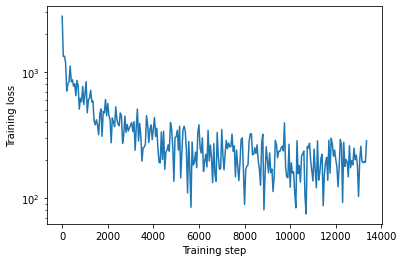

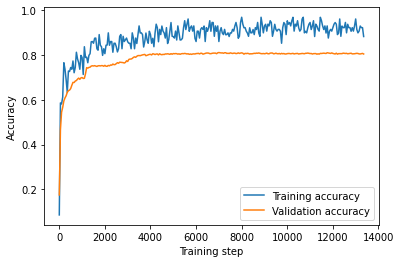

In [36]:
plt.figure()
plt.plot(np.arange(len(results['train_loss'])) * print_every, results['train_loss'])
plt.xlabel('Training step')
plt.ylabel('Training loss')
plt.yscale('log')

plt.figure()
plt.plot(np.arange(len(results['train_loss'])) * print_every, results['train_acc'], label='Training accuracy')
plt.plot(np.arange(len(results['train_loss'])) * print_every, results['val_acc'], label='Validation accuracy')
plt.xlabel('Training step')
plt.ylabel('Accuracy')
plt.legend()

## Exercise 4 - optimizers

PyTorch provides a number of different optimizers for us to choose from. Replace `optim.SGD` with any of `optim.RMSprop`, `optim.Adagrad` and `optim.Adam` and experiment with the number of layers and hidden units to find the best possible network.

In [37]:
batch_size = 128
learning_rate = 0.001
n_epochs = 100
print_every = 50
num_hidden = 20

# build the neural network
layer_1 = layer(input_size, num_hidden, activation=nn.ReLU())
layer_2 = layer(num_hidden, num_classes, activation=nn.Softmax(dim=-1))

model = nn.Sequential(layer_1, layer_2)

# =========
# create the optimizer
optimizer = optim.Adam(
    model.parameters(),
    lr=learning_rate
)
# =========

# train the network
step = 0
results = {
    'train_loss': [],
    'train_acc': [],
    'val_acc': [],
}
for epoch in range(n_epochs):
    # randomize the order in which we see the data in each epoch
    random_order_indices = np.random.choice(train_tensor.shape[0], train_tensor.shape[0], replace=False)
    
    # iterate through the data in batches of size `batch_size`
    for batch_indices in np.array_split(random_order_indices, random_order_indices.shape[0] // batch_size):
      
        train_data_batch = train_tensor[batch_indices]
        train_labels_batch = train_labels[batch_indices]
        train_onehot = to_one_hot(train_labels_batch, num_classes)

        step += 1

        # get pass batch through layers
        output = model(train_data_batch)

        # compute cross entropy
        loss = train_onehot * torch.log(output+ 1e-6) + (1 - train_onehot) * torch.log(1 - output + 1e-6)
        loss = -1 * loss.sum()

        # backpropagate the loss
        loss.backward()

        # update parameters
        optimizer.step()

        # reset gradients
        optimizer.zero_grad()

        # evaluate accuracy on both the training and validation datasets
        if step % print_every == 0:
            
            # don't track gradients
            with torch.no_grad():
                # compute the predicted outputs
                train_prediction = output.argmax(1).numpy()

                # compute the accuracy over the batch
                acc_training = np.mean(train_prediction == train_labels_batch.numpy())

                # compute the loss on all the validation data
                loss_np = []
                output_np = []
                labels_np = []

                random_order_indices = np.random.choice(valid_tensor.shape[0], valid_tensor.shape[0], replace=False)

                for batch_indices in np.array_split(random_order_indices, random_order_indices.shape[0] // batch_size):
                    valid_data_batch = valid_tensor[batch_indices]
                    valid_labels_batch = valid_labels[batch_indices]

                    # pass through layers
                    valid_output = model(valid_data_batch)

                    # compute the predicted outputs

                    prediction_np = valid_output.argmax(1).numpy()

                    output_np.append(prediction_np.reshape(-1))
                    labels_np.append(valid_labels_batch.numpy().reshape(-1))

                    
                # compute the accuracy over the whole dataset
                output_np = np.concatenate(output_np)
                labels_np = np.concatenate(labels_np)
                acc_validation = np.mean(output_np == labels_np)

                results['train_loss'].append(loss.item())
                results['train_acc'].append(acc_training)
                results['val_acc'].append(acc_validation)
                print('Step {} loss: {:.3f} training accuracy: {:.3f} validation accuracy: {:.3f} '.format(
                    step, loss.item(), acc_training, acc_validation))

Step 50 loss: 2194.418 training accuracy: 0.178 validation accuracy: 0.096 
Step 100 loss: 1918.636 training accuracy: 0.227 validation accuracy: 0.112 
Step 150 loss: 2026.711 training accuracy: 0.171 validation accuracy: 0.124 
Step 200 loss: 1946.449 training accuracy: 0.264 validation accuracy: 0.138 
Step 250 loss: 1908.347 training accuracy: 0.219 validation accuracy: 0.148 
Step 300 loss: 1662.315 training accuracy: 0.333 validation accuracy: 0.158 
Step 350 loss: 1685.228 training accuracy: 0.295 validation accuracy: 0.172 
Step 400 loss: 1608.524 training accuracy: 0.328 validation accuracy: 0.184 
Step 450 loss: 1491.400 training accuracy: 0.349 validation accuracy: 0.192 
Step 500 loss: 1586.300 training accuracy: 0.289 validation accuracy: 0.199 
Step 550 loss: 1579.022 training accuracy: 0.318 validation accuracy: 0.213 
Step 600 loss: 1579.818 training accuracy: 0.295 validation accuracy: 0.223 
Step 650 loss: 1359.426 training accuracy: 0.359 validation accuracy: 0.236 


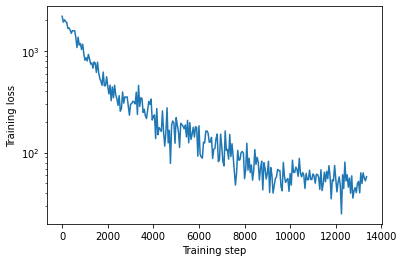

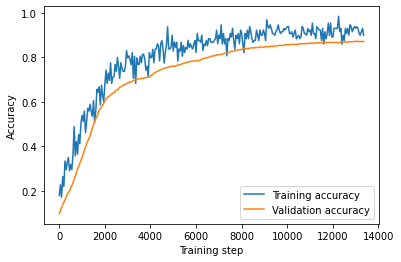

In [38]:
plt.figure()
plt.plot(np.arange(len(results['train_loss'])) * print_every, results['train_loss'])
plt.xlabel('Training step')
plt.ylabel('Training loss')
plt.yscale('log')

plt.figure()
plt.plot(np.arange(len(results['train_loss'])) * print_every, results['train_acc'], label='Training accuracy')
plt.plot(np.arange(len(results['train_loss'])) * print_every, results['val_acc'], label='Validation accuracy')
plt.xlabel('Training step')
plt.ylabel('Accuracy')
plt.legend()

## Exercise 4 - network depth

Create a network with *two* hidden layers and compare its performance to the network with one hidden layer we just built. Try increasing the number of epochs if the loss hasn't stopped increasing.

In [39]:
# let's set some hyperparameters
batch_size = 128
# ========
# as you add an additional layer, you may wish to decrease the learning rate
# if the network hasn't finished improving after 100 epochs, you can train it for longer
learning_rate = 0.001
n_epochs = 100
# ========
print_every = 50
num_hidden = 20

# build the neural network
# ========
# Create a network with three hidden layers
layer_1 = layer(input_size, num_hidden, activation=nn.ReLU())
layer_2 = layer(num_hidden, num_hidden, activation=nn.ReLU())
layer_3 = layer(num_hidden, num_classes, activation=nn.Softmax(dim=-1))
# create the model
model = nn.Sequential(layer_1, layer_2, layer_3)
# ========

# create the optimizer
optimizer = optim.Adam(model.parameters(),
                       lr=learning_rate)

# train the network
step = 0
results = {
    'train_loss': [],
    'train_acc': [],
    'val_acc': [],
}
for epoch in range(n_epochs):
    # randomize the order in which we see the data in each epoch
    random_order_indices = np.random.choice(train_tensor.shape[0], train_tensor.shape[0], replace=False)
    
    # iterate through the data in batches of size `batch_size`
    for batch_indices in np.array_split(random_order_indices, random_order_indices.shape[0] // batch_size):
      
        train_data_batch = train_tensor[batch_indices]
        train_labels_batch = train_labels[batch_indices]
        train_onehot = to_one_hot(train_labels_batch, num_classes)

        step += 1

        # get pass batch through layers
        output = model(train_data_batch)

        # compute cross entropy
        loss = train_onehot * torch.log(output+ 1e-6) + (1 - train_onehot) * torch.log(1 - output + 1e-6)
        loss = -1 * loss.sum()

        # backpropagate the loss
        loss.backward()

        # update parameters
        optimizer.step()

        # reset gradients
        optimizer.zero_grad()

        # evaluate accuracy on both the training and validation datasets
        if step % print_every == 0:
            
            # don't track gradients
            with torch.no_grad():
                # compute the predicted outputs
                train_prediction = output.argmax(1).numpy()

                # compute the accuracy over the batch
                acc_training = np.mean(train_prediction == train_labels_batch.numpy())

                # compute the loss on all the validation data
                loss_np = []
                output_np = []
                labels_np = []

                random_order_indices = np.random.choice(valid_tensor.shape[0], valid_tensor.shape[0], replace=False)

                for batch_indices in np.array_split(random_order_indices, random_order_indices.shape[0] // batch_size):
                    valid_data_batch = valid_tensor[batch_indices]
                    valid_labels_batch = valid_labels[batch_indices]

                    # pass through layers
                    valid_output = model(valid_data_batch)

                    # compute the predicted outputs

                    prediction_np = valid_output.argmax(1).numpy()

                    output_np.append(prediction_np.reshape(-1))
                    labels_np.append(valid_labels_batch.numpy().reshape(-1))

                    
                # compute the accuracy over the whole dataset
                output_np = np.concatenate(output_np)
                labels_np = np.concatenate(labels_np)
                acc_validation = np.mean(output_np == labels_np)

                results['train_loss'].append(loss.item())
                results['train_acc'].append(acc_training)
                results['val_acc'].append(acc_validation)
                print('Step {} loss: {:.3f} training accuracy: {:.3f} validation accuracy: {:.3f} '.format(
                    step, loss.item(), acc_training, acc_validation))

Step 50 loss: 3180.621 training accuracy: 0.000 validation accuracy: 0.017 
Step 100 loss: 3032.160 training accuracy: 0.008 validation accuracy: 0.018 
Step 150 loss: 3014.863 training accuracy: 0.016 validation accuracy: 0.022 
Step 200 loss: 2923.616 training accuracy: 0.008 validation accuracy: 0.025 
Step 250 loss: 2782.037 training accuracy: 0.055 validation accuracy: 0.032 
Step 300 loss: 2769.400 training accuracy: 0.054 validation accuracy: 0.044 
Step 350 loss: 2665.389 training accuracy: 0.054 validation accuracy: 0.066 
Step 400 loss: 2341.149 training accuracy: 0.188 validation accuracy: 0.097 
Step 450 loss: 2034.805 training accuracy: 0.279 validation accuracy: 0.138 
Step 500 loss: 1974.280 training accuracy: 0.312 validation accuracy: 0.164 
Step 550 loss: 2051.397 training accuracy: 0.310 validation accuracy: 0.183 
Step 600 loss: 2179.724 training accuracy: 0.248 validation accuracy: 0.194 
Step 650 loss: 1953.647 training accuracy: 0.344 validation accuracy: 0.202 


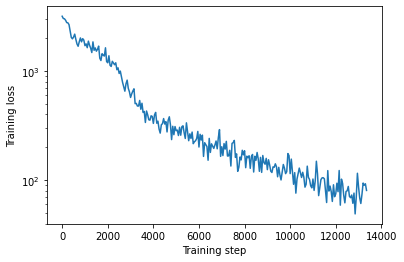

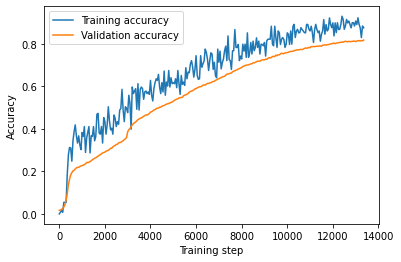

In [40]:
plt.figure()
plt.plot(np.arange(len(results['train_loss'])) * print_every, results['train_loss'])
plt.xlabel('Training step')
plt.ylabel('Training loss')
plt.yscale('log')

plt.figure()
plt.plot(np.arange(len(results['train_loss'])) * print_every, results['train_acc'], label='Training accuracy')
plt.plot(np.arange(len(results['train_loss'])) * print_every, results['val_acc'], label='Validation accuracy')
plt.xlabel('Training step')
plt.ylabel('Accuracy')
plt.legend()

## Exercise 5 - activation functions

PyTorch provides a number of different activations for us to choose from. Replace `nn.ReLU` with any of `nn.Tanh`, `nn.Sigmoid` and `nn.LeakyReLU` or any others you find in the PyTorch docs to build the best possible network.

In [41]:
# ======
# create and train the neural network as above
# replace the activation function with your choice of activation
# let's set some hyperparameters
batch_size = 128
# ========
# as you add an additional layer, you may wish to decrease the learning rate
# if the network hasn't finished improving after 100 epochs, you can train it for longer
learning_rate = 0.001
n_epochs = 100
# ========
print_every = 50
num_hidden = 20

# build the neural network
# ========
# Create a network with three hidden layers
layer_1 = layer(input_size, num_hidden, activation=nn.LeakyReLU())
layer_2 = layer(num_hidden, num_hidden, activation=nn.LeakyReLU())
layer_3 = layer(num_hidden, num_classes, activation=nn.Softmax(dim=-1))
# create the model
model = nn.Sequential(layer_1, layer_2, layer_3)
# ========

# create the optimizer
optimizer = optim.Adam(model.parameters(),
                       lr=learning_rate)

# train the network
step = 0
results = {
    'train_loss': [],
    'train_acc': [],
    'val_acc': [],
}
for epoch in range(n_epochs):
    # randomize the order in which we see the data in each epoch
    random_order_indices = np.random.choice(train_tensor.shape[0], train_tensor.shape[0], replace=False)
    
    # iterate through the data in batches of size `batch_size`
    for batch_indices in np.array_split(random_order_indices, random_order_indices.shape[0] // batch_size):
      
        train_data_batch = train_tensor[batch_indices]
        train_labels_batch = train_labels[batch_indices]
        train_onehot = to_one_hot(train_labels_batch, num_classes)

        step += 1

        # get pass batch through layers
        output = model(train_data_batch)

        # compute cross entropy
        loss = train_onehot * torch.log(output+ 1e-6) + (1 - train_onehot) * torch.log(1 - output + 1e-6)
        loss = -1 * loss.sum()

        # backpropagate the loss
        loss.backward()

        # update parameters
        optimizer.step()

        # reset gradients
        optimizer.zero_grad()

        # evaluate accuracy on both the training and validation datasets
        if step % print_every == 0:
            
            # don't track gradients
            with torch.no_grad():
                # compute the predicted outputs
                train_prediction = output.argmax(1).numpy()

                # compute the accuracy over the batch
                acc_training = np.mean(train_prediction == train_labels_batch.numpy())

                # compute the loss on all the validation data
                loss_np = []
                output_np = []
                labels_np = []

                random_order_indices = np.random.choice(valid_tensor.shape[0], valid_tensor.shape[0], replace=False)

                for batch_indices in np.array_split(random_order_indices, random_order_indices.shape[0] // batch_size):
                    valid_data_batch = valid_tensor[batch_indices]
                    valid_labels_batch = valid_labels[batch_indices]

                    # pass through layers
                    valid_output = model(valid_data_batch)

                    # compute the predicted outputs

                    prediction_np = valid_output.argmax(1).numpy()

                    output_np.append(prediction_np.reshape(-1))
                    labels_np.append(valid_labels_batch.numpy().reshape(-1))

                    
                # compute the accuracy over the whole dataset
                output_np = np.concatenate(output_np)
                labels_np = np.concatenate(labels_np)
                acc_validation = np.mean(output_np == labels_np)

                results['train_loss'].append(loss.item())
                results['train_acc'].append(acc_training)
                results['val_acc'].append(acc_validation)
                print('Step {} loss: {:.3f} training accuracy: {:.3f} validation accuracy: {:.3f} '.format(
                    step, loss.item(), acc_training, acc_validation))
# ======

Step 50 loss: 3152.508 training accuracy: 0.016 validation accuracy: 0.007 
Step 100 loss: 3039.954 training accuracy: 0.000 validation accuracy: 0.009 
Step 150 loss: 2908.451 training accuracy: 0.031 validation accuracy: 0.013 
Step 200 loss: 3004.229 training accuracy: 0.016 validation accuracy: 0.017 
Step 250 loss: 2961.146 training accuracy: 0.016 validation accuracy: 0.023 
Step 300 loss: 2933.175 training accuracy: 0.016 validation accuracy: 0.029 
Step 350 loss: 2739.289 training accuracy: 0.031 validation accuracy: 0.039 
Step 400 loss: 2905.981 training accuracy: 0.023 validation accuracy: 0.050 
Step 450 loss: 2556.346 training accuracy: 0.070 validation accuracy: 0.054 
Step 500 loss: 2616.882 training accuracy: 0.070 validation accuracy: 0.061 
Step 550 loss: 2444.581 training accuracy: 0.132 validation accuracy: 0.074 
Step 600 loss: 2700.160 training accuracy: 0.070 validation accuracy: 0.073 
Step 650 loss: 2601.859 training accuracy: 0.070 validation accuracy: 0.073 


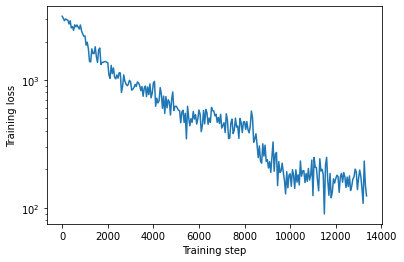

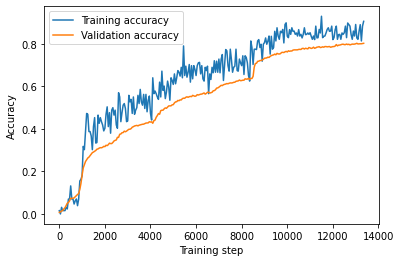

In [42]:
plt.figure()
plt.plot(np.arange(len(results['train_loss'])) * print_every, results['train_loss'])
plt.xlabel('Training step')
plt.ylabel('Training loss')
plt.yscale('log')

plt.figure()
plt.plot(np.arange(len(results['train_loss'])) * print_every, results['train_acc'], label='Training accuracy')
plt.plot(np.arange(len(results['train_loss'])) * print_every, results['val_acc'], label='Validation accuracy')
plt.xlabel('Training step')
plt.ylabel('Accuracy')
plt.legend()
# ======

## Exercise 6 - more network depth

Create a network with *five* hidden layers and compare its performance to the network with one hidden layer we just built

In [43]:
# ======
# create and train the neural network as above
# replace the three-layer network with five layers
# as you add further additional layers, you may wish to decrease the learning rate, e.g. to 0.0001
# if the network hasn't finished improving after 100 epochs, you can train it for longer
# let's set some hyperparameters
batch_size = 128
# ========
# as you add an additional layer, you may wish to decrease the learning rate
# if the network hasn't finished improving after 100 epochs, you can train it for longer
learning_rate = 0.001
n_epochs = 100
# ========
print_every = 50
num_hidden = 20

# build the neural network
# ========

layer_1 = layer(input_size, num_hidden, activation=nn.LeakyReLU())
# Create a network with three hidden layers
layer_2 = layer(num_hidden, num_hidden, activation=nn.LeakyReLU())
layer_3 = layer(num_hidden, num_hidden, activation=nn.LeakyReLU())
layer_4 = layer(num_hidden, num_hidden, activation=nn.LeakyReLU())
layer_5 = layer(num_hidden, num_hidden, activation=nn.LeakyReLU())

layer_6 = layer(num_hidden, num_classes, activation=nn.Softmax(dim=-1))
# create the model
model = nn.Sequential(layer_1, layer_2, layer_3, layer_4, layer_5, layer_6)
# ========

# create the optimizer
optimizer = optim.Adam(model.parameters(),
                       lr=learning_rate)

# train the network
step = 0
results = {
    'train_loss': [],
    'train_acc': [],
    'val_acc': [],
}
for epoch in range(n_epochs):
    # randomize the order in which we see the data in each epoch
    random_order_indices = np.random.choice(train_tensor.shape[0], train_tensor.shape[0], replace=False)
    
    # iterate through the data in batches of size `batch_size`
    for batch_indices in np.array_split(random_order_indices, random_order_indices.shape[0] // batch_size):
      
        train_data_batch = train_tensor[batch_indices]
        train_labels_batch = train_labels[batch_indices]
        train_onehot = to_one_hot(train_labels_batch, num_classes)

        step += 1

        # get pass batch through layers
        output = model(train_data_batch)

        # compute cross entropy
        loss = train_onehot * torch.log(output+ 1e-6) + (1 - train_onehot) * torch.log(1 - output + 1e-6)
        loss = -1 * loss.sum()

        # backpropagate the loss
        loss.backward()

        # update parameters
        optimizer.step()

        # reset gradients
        optimizer.zero_grad()

        # evaluate accuracy on both the training and validation datasets
        if step % print_every == 0:
            
            # don't track gradients
            with torch.no_grad():
                # compute the predicted outputs
                train_prediction = output.argmax(1).numpy()

                # compute the accuracy over the batch
                acc_training = np.mean(train_prediction == train_labels_batch.numpy())

                # compute the loss on all the validation data
                loss_np = []
                output_np = []
                labels_np = []

                random_order_indices = np.random.choice(valid_tensor.shape[0], valid_tensor.shape[0], replace=False)

                for batch_indices in np.array_split(random_order_indices, random_order_indices.shape[0] // batch_size):
                    valid_data_batch = valid_tensor[batch_indices]
                    valid_labels_batch = valid_labels[batch_indices]

                    # pass through layers
                    valid_output = model(valid_data_batch)

                    # compute the predicted outputs

                    prediction_np = valid_output.argmax(1).numpy()

                    output_np.append(prediction_np.reshape(-1))
                    labels_np.append(valid_labels_batch.numpy().reshape(-1))

                    
                # compute the accuracy over the whole dataset
                output_np = np.concatenate(output_np)
                labels_np = np.concatenate(labels_np)
                acc_validation = np.mean(output_np == labels_np)

                results['train_loss'].append(loss.item())
                results['train_acc'].append(acc_training)
                results['val_acc'].append(acc_validation)
                print('Step {} loss: {:.3f} training accuracy: {:.3f} validation accuracy: {:.3f} '.format(
                    step, loss.item(), acc_training, acc_validation))
# ======

Step 50 loss: 3498.605 training accuracy: 0.016 validation accuracy: 0.004 
Step 100 loss: 3505.069 training accuracy: 0.000 validation accuracy: 0.005 
Step 150 loss: 3530.267 training accuracy: 0.008 validation accuracy: 0.005 
Step 200 loss: 3442.582 training accuracy: 0.023 validation accuracy: 0.007 
Step 250 loss: 3501.817 training accuracy: 0.008 validation accuracy: 0.010 
Step 300 loss: 3490.964 training accuracy: 0.016 validation accuracy: 0.014 
Step 350 loss: 3469.690 training accuracy: 0.023 validation accuracy: 0.017 
Step 400 loss: 3294.433 training accuracy: 0.062 validation accuracy: 0.034 
Step 450 loss: 3333.578 training accuracy: 0.062 validation accuracy: 0.064 
Step 500 loss: 3056.821 training accuracy: 0.133 validation accuracy: 0.111 
Step 550 loss: 2578.437 training accuracy: 0.271 validation accuracy: 0.160 
Step 600 loss: 2486.786 training accuracy: 0.302 validation accuracy: 0.189 
Step 650 loss: 2278.074 training accuracy: 0.352 validation accuracy: 0.209 


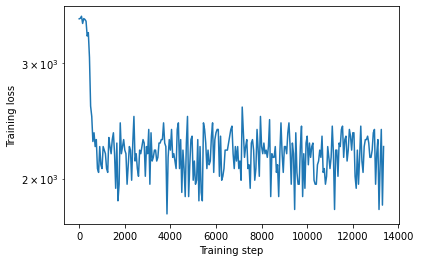

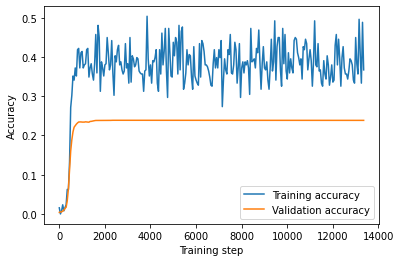

In [44]:
plt.figure()
plt.plot(np.arange(len(results['train_loss'])) * print_every, results['train_loss'])
plt.xlabel('Training step')
plt.ylabel('Training loss')
plt.yscale('log')

plt.figure()
plt.plot(np.arange(len(results['train_loss'])) * print_every, results['train_acc'], label='Training accuracy')
plt.plot(np.arange(len(results['train_loss'])) * print_every, results['val_acc'], label='Validation accuracy')
plt.xlabel('Training step')
plt.ylabel('Accuracy')
plt.legend()

### Discussion

1. How did the more complex networks you built compare to the simple network we started with?
  - none of them performed any better. the more complex networks took longer to train, and the deepest network failed to learn anything
2. Which was more useful -- adding _depth_ to your network or adding width?
  - adding some depth is helpful, but too much can make training difficult. adding too much width didn't help much
3. Which optimizer performed best?
  - Adam performs best and has the smoothest convergence, though on the simpler networks SGD did surprisingly well
4. What had the biggest effect on performance: depth, width, or optimizer?
  - the optimizer has the biggest effect
  
#### Re-Cap
1. Power of PyTorch is to allow us to setup the neural networks using nn.Module

2. We can use the same neural network over and over with different data without having to re-write the code.

In [45]:
! rm data.pickle.gz
! rm metadata.pickle.gz